In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

In [3]:
import torch
from torch_geometric.utils import to_scipy_sparse_matrix

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
%run setup_notebooks.py

In [5]:
from src import setup

In [6]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [7]:
%matplotlib inline

In [8]:
from torch_geometric.utils import k_hop_subgraph

def plot_subgraph(data, k_hop, central_node, directed: bool = False, transparent: bool = False, ax: bool = None, nodesize=50):
    sub_nodes, sub_edge_index, central_node, _ = k_hop_subgraph(central_node, k_hop, data.edge_index)
    
    node_xyz = data.coord[sub_nodes, :].numpy()
    edge_xyz = np.array([
        (data.coord[u].numpy(), data.coord[v].numpy()) for u, v in sub_edge_index.T
    ])
    
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
    
    # Plot edges
    if directed is False:
        alpha = 0.1 if transparent else 0.3
        for vizedge in edge_xyz:
            ax.plot(*vizedge.T, color='k', alpha=alpha)
    else:
        start_edges = sub_edge_index[1, :]
        
        locX, locY, locZ = data.coord[start_edges].T
        
        end_edges = sub_edge_index[0, :]
        locX2, locY2, locZ2 = data.coord[end_edges].T
        
        dirX, dirY, dirZ = locX2 - locX, locY2 - locY, locZ2 - locZ
        
        alpha = 0.3 if transparent else 0.6
        ax.quiver(locX, locY, locZ, dirX, dirY, dirZ, alpha=alpha)

    # Plot nodes
    color = 'green' if transparent else 'blue'
    ax.scatter3D(*node_xyz.T, s=nodesize, color=color)
    # Plot central node in red
    ax.scatter3D(*node_xyz[central_node].T, color='red', s=2*nodesize)

In [9]:
path = setup.get_dataset_path('CoordToCnc')

file = path.joinpath('OLV047_LCX.pt')
assert file.exists()

2022-05-02 16:45:26,127 [setup] [INFO] get_data_path(): using user-defined data path


In [10]:
data = torch.load(file)
data

Data(x=[6416, 0], edge_index=[2, 38392], y=1, coord=[6416, 3], g_x=[1, 3])

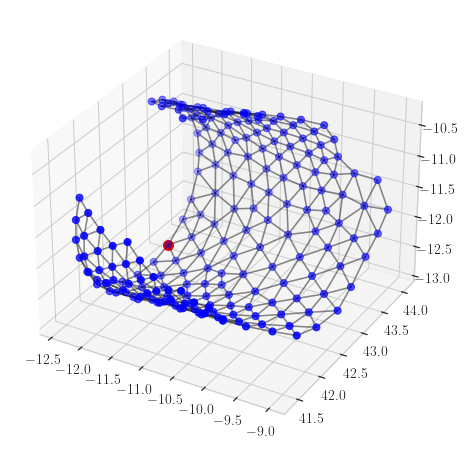

In [13]:
plot_subgraph(data, 10, 0, )

---

In [15]:
from torch_geometric.utils import to_scipy_sparse_matrix

In [17]:
nnz_r, nnz_c = to_scipy_sparse_matrix(data.edge_index).nonzero()

In [18]:
nnz_r, nnz_c

(array([   1,    2,    2, ..., 6408, 6412, 6413], dtype=int32),
 array([   0,    0,    1, ..., 6415, 6415, 6415], dtype=int32))

In [14]:
def get_neighbours(nnz_r, nnz_c, i):
    mask = nnz_r == i
    return nnz_c[mask]

In [21]:
get_neighbours(nnz_r, nnz_c, 0)

array([ 1,  2, 21, 22], dtype=int32)

In [94]:
def find_init_annulus(nnz_r, nnz_c, start_node, maxiter=1000):
    # Set of visited nodes for efficient computations
    annulus = set([start_node])
    # List of visited nodes to keep trace of the order
    nodes = [start_node]
    
    current = start_node
    hop_counter = 0
    while hop_counter < maxiter:
    #while current != start_node or hop_counter == 0:
        # Neighbours of current nodes
        unfiltered_neighs = set(get_neighbours(nnz_r, nnz_c, current))
        # Remove already-visited nodes
        neighs = unfiltered_neighs.difference(annulus)
        
        # Detect termination: got back to the original node
        if hop_counter > 1 and start_node in unfiltered_neighs:
            return nodes
        
        # Compute degree of each neighbour
        n_neighs = {
            (i, len(get_neighbours(nnz_r, nnz_c, i))) for i in neighs
        }
        # Select neighbour with minimal degree
        next_node = min(n_neighs, key=lambda e: e[1])[0]
        
        # Add selected node
        annulus.add(next_node)
        nodes.append(next_node)
        hop_counter += 1
        current = next_node
    
    return nodes

In [43]:
from torch_geometric.utils import subgraph as torch_subgraph

In [70]:
def subgraph(data, keep_nodes):
    out = data.clone()
    out.x = data.x[keep_nodes]
    out.edge_index = torch_subgraph(keep_nodes, out.edge_index, relabel_nodes=True)[0]
    out.coord = out.coord[keep_nodes]
    return out

[0, 21, 38, 37, 35, 33, 32, 30, 29, 27, 26, 24, 23, 19, 18, 16, 15, 13, 12, 10, 9, 7, 6, 4, 3, 1]
Data(x=[26, 0], edge_index=[2, 52], y=1, coord=[26, 3], g_x=[1, 3])


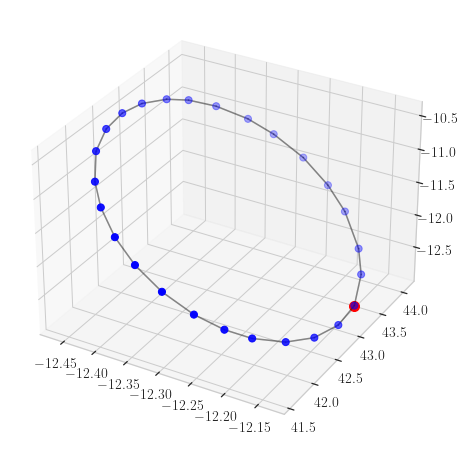

In [97]:
annulus = find_init_annulus(nnz_r, nnz_c, 0, maxiter=300)
print(annulus)

data_annulus = subgraph(data, annulus)
print(data_annulus)

plot_subgraph(data_annulus, 30, 0)

In [187]:
from scipy.spatial import distance_matrix

def avg_diameter(subgraph_annulus):
    D = distance_matrix(subgraph_annulus.coord, subgraph_annulus.coord)
    max_dist = np.max(D, axis=1)
    return max_dist.mean(), max_dist.std()

In [188]:
avg_diameter(data_annulus)

(2.4802765667547884, 0.07810827618019853)

In [210]:
def find_next_annulus(nnz_r, nnz_c, prev_annulus, prevprev_annulus=None):
    # Get neighbours of current annulus
    neighs = set()
    for node in prev_annulus:
        neighs.update(get_neighbours(nnz_r, nnz_c, node))
    
    # Remove already visited nodes
    neighs.difference_update(prev_annulus)
    if prevprev_annulus is not None:
        neighs.difference_update(prevprev_annulus)
        
    return list(map(int, neighs))

In [203]:
def find_next_annulus(nnz_r, nnz_c, prev_annulus, D, prevprev_annulus=None):
    # Get neighbours of current annulus
    neighs = set()
    for node in prev_annulus:
        neighs.update(get_neighbours(nnz_r, nnz_c, node))
    
    # Start with some "new" neighbours
    new_neigh = neighs.difference(prev_annulus)
    candidate_neigh = new_neigh.copy()
    if prevprev_annulus is not None:
        new_neigh = new_neigh.difference(prevprev_annulus)
    
    start = next(iter(new_neigh))
    current = start
    counter = 0
    annulus = [start]
    while True:
        closest = np.argmin(D[current, :])
        if closest not in candidate_neigh:
            raise ValueError
        
        annulus.append(closest)
        current = closest
        counter += 1
    
    return list(map(int, annulus))

In [143]:
%matplotlib widget

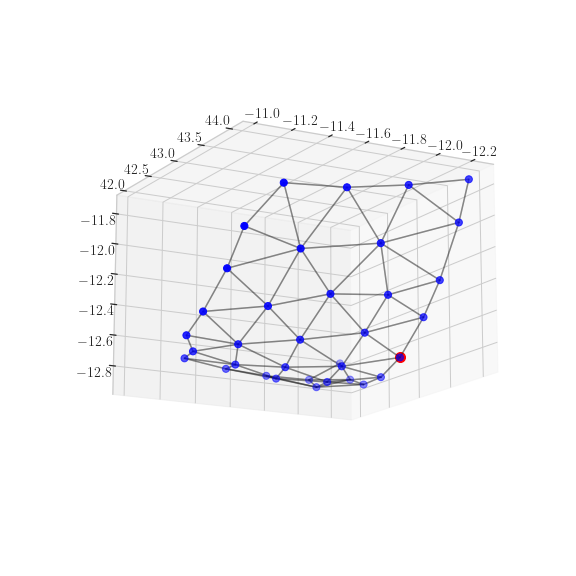

In [177]:
plot_subgraph(data, 4, 0)
plt.gca().view_init(*viewangles)

In [205]:
D = distance_matrix(data.coord, data.coord)

In [208]:
test = find_next_annulus(nnz_r, nnz_c, annulus, D)
test = subgraph(data, test)
plot_subgraph(test, 30, 0)
plt.gca().view_init(*viewangles)

KeyboardInterrupt: 

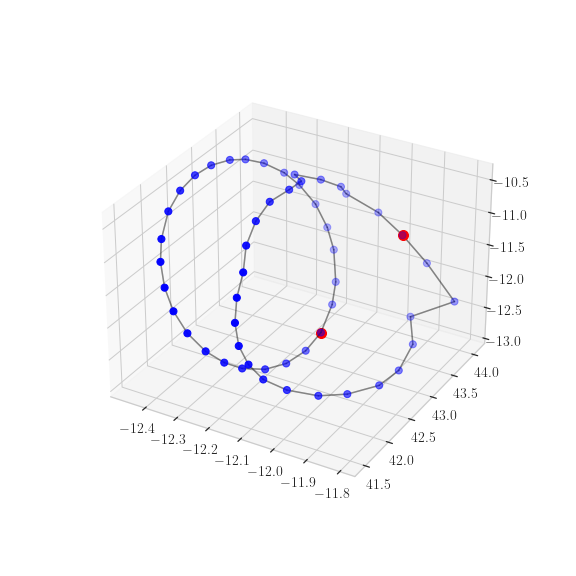

In [154]:
annulus_2 = find_next_annulus(nnz_r, nnz_c, annulus)
data_annulus_2 = subgraph(data, annulus_2)
plot_subgraph(data_annulus, 30, 0)
plot_subgraph(data_annulus_2, 30, annulus_2[0], ax=plt.gca())
viewangles = plt.gca().elev, plt.gca().azim

In [163]:
viewangles = plt.gca().elev, plt.gca().azim

In [137]:
def get_annuluses(data, start_node=0, maxiter=10):
    nnz_r, nnz_c = to_scipy_sparse_matrix(data.edge_index).nonzero()
    init = find_init_annulus(nnz_r, nnz_c, start_node)
    ls = [None, init]
    for i in range(maxiter):
        ls.append(find_next_annulus(nnz_r, nnz_c, ls[-1], ls[-2]))
    
    ls.pop(0)
    return ls

0
1
2
3
4


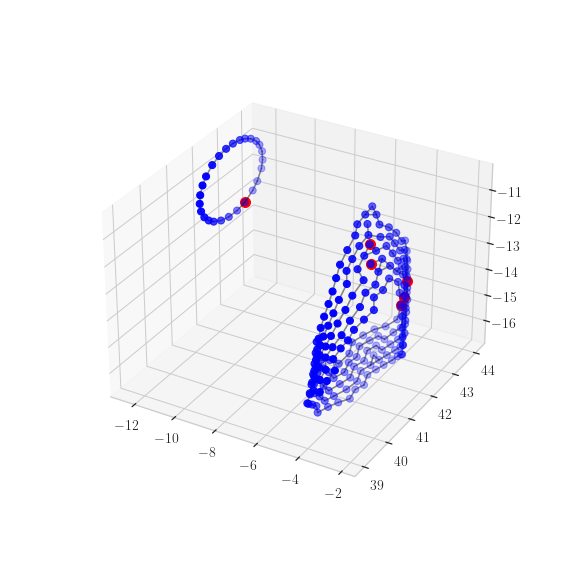

In [217]:
ls = get_annuluses(data, maxiter=30)
i0 = 0
tmp = subgraph(data, ls[i0])
plot_subgraph(tmp, 50, 0)

for i, l in enumerate(ls[i0+25:i0+30]):
    print(i)
    tmp = subgraph(data, l)
    plot_subgraph(tmp, 50, 0, ax=plt.gca())